In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import configparser
from pathlib import Path
import os
%matplotlib inline

from darts import TimeSeries
from darts.models import NBEATSModel
from darts.metrics import mae, mse, rmse, mape

Importing plotly failed. Interactive plots will not work.


In [2]:
configs = configparser.ConfigParser()
configs.read("configuracoes.conf",encoding='utf-8')

data_folder = Path(configs["DEFAULT"]["folder_path"])
path = data_folder / configs["DEFAULT"]["file"]
qtd_Meses = int(configs["DEFAULT"]["meses"])
objeto = configs["DEFAULT"]["objeto"]
regiao = configs["DEFAULT"]["regiao"]

df = pd.read_excel(path, parse_dates=['ano'])

#Normalizar
#df.preco = df.preco / 1000

#Dividir os dados em Treino e Validação
train_cesta = df.iloc[:-qtd_Meses:]
val_cesta = df.iloc[-qtd_Meses::]

#Criar TimeSeries usando os DataFrame
train_cesta = TimeSeries.from_dataframe(train_cesta, 'ano', 'razao')
val_cesta = TimeSeries.from_dataframe(val_cesta, 'ano', 'razao')
cesta = TimeSeries.from_dataframe(df, 'ano', 'razao')

#ajustar dados para grafico
grafico_train = df.iloc[4 * -qtd_Meses::].copy()
grafico_train = grafico_train.iloc[:-qtd_Meses + 1:].copy()
grafico_train.reset_index(drop=True, inplace=True)
grafico_val = df.iloc[-qtd_Meses::].copy()

[2022-03-03 10:13:39,417] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 156 samples.
[2022-03-03 10:13:39,417] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 156 samples.
[2022-03-03 10:13:39,575] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-03 10:13:39,575] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | MSELoss    | 0     
1 | stacks    | ModuleList | 12.6 M
-----------------------------------------
12.6 M    Trainable params
1.5 K     Non-trainable params
12.6 M    Total params
100.767   Total estimated model params size (MB)


Epoch 34: 100%|██████████| 5/5 [00:01<00:00,  3.99it/s, loss=0.000901]
Predicting: 5it [00:00, ?it/s]

MAE : 0.04583
MSE :0.00274
RMSE :0.05239
MAPE :10.744%


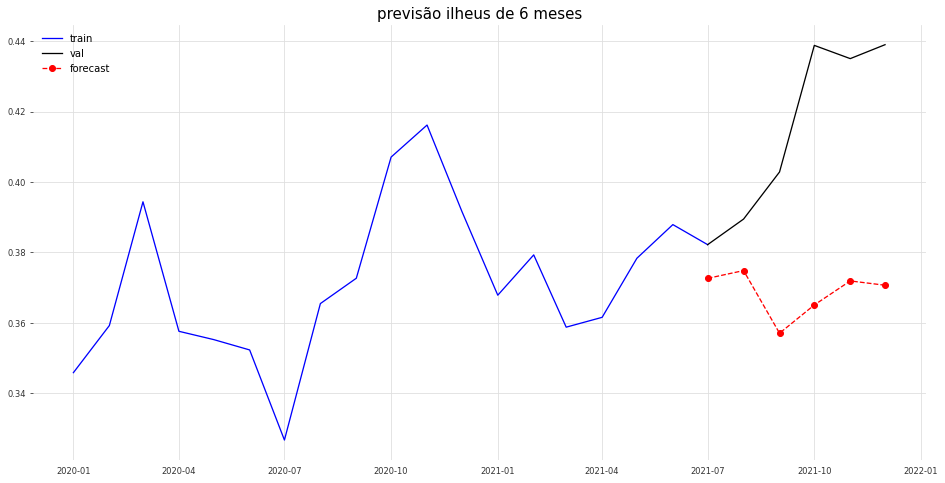

In [3]:
model_NBeast = NBEATSModel(input_chunk_length = 37, output_chunk_length= qtd_Meses, n_epochs = 35,
               num_stacks=30, layer_widths=256, generic_architecture=True, num_blocks = 2) 
 
model_NBeast.fit(series = [train_cesta])

forecast = model_NBeast.predict(len(val_cesta), series=train_cesta) 

print('\nMAE : {:.5f}\nMSE :{:.5f}\nRMSE :{:.5f}\nMAPE :{:.3f}%'.format(mae(val_cesta, forecast),
        mse(val_cesta, forecast), rmse(val_cesta, forecast), mape(val_cesta, forecast)))

forecast = forecast.pd_dataframe()
forecast.reset_index(inplace = True)

resultados = [round(previsao, 5) for previsao in forecast.razao.values]
objeto = objeto.replace(" ",'_')
output = {objeto.lower():str(resultados)}
filename = f"previsao_N-Beast_{objeto.lower()}_{regiao.lower()}_{qtd_Meses}_meses.json"
pasta_atual = os.getcwd()
full_url = Path(pasta_atual) / 'resultados' / 'previsoes' / filename
os.makedirs(os.path.dirname(full_url), exist_ok=True)
with open(full_url,"w") as file:
    json.dump(output,file,ensure_ascii=False)

fig = plt.figure(figsize=(16, 8))
plt.title(f"previsão {regiao} de {qtd_Meses} meses", size=15)
plt.plot(grafico_train.ano, grafico_train.razao, label = 'train', color = 'blue')
plt.plot(grafico_val.ano, grafico_val.razao, label = 'val', color = 'black')
plt.plot(forecast.ano, forecast.razao, label = 'forecast', color = 'red', ls = '--', marker = 'o')
plt.legend()

## Avaliar os melhores hyperparametros

In [4]:
"""
parameters = {"input_chunk_length": [12, 18, 24, 37],
            "output_chunk_length": [qtd_Meses],
            'n_epochs': [35, 50], 
            'num_stacks': [10, 20, 30], 
            'num_blocks': [1, 2], 
            'layer_widths':[64, 128, 256]
}

grid = NBEATSModel.gridsearch(parameters=parameters, series=train_cesta, val_series=val_cesta, start=0.1, 
                            metric=mape, verbose=True)

best_model, best_params = grid
"""

'\nparameters = {"input_chunk_length": [12, 18, 24, 37],\n            "output_chunk_length": [qtd_Meses],\n            \'n_epochs\': [35, 50], \n            \'num_stacks\': [10, 20, 30], \n            \'num_blocks\': [1, 2], \n            \'layer_widths\':[64, 128, 256]\n}\n\ngrid = NBEATSModel.gridsearch(parameters=parameters, series=train_cesta, val_series=val_cesta, start=0.1, \n                            metric=mape, verbose=True)\n\nbest_model, best_params = grid\n'

In [5]:
#print(best_params)
#{'input_chunk_length': 37,
#  'output_chunk_length': 6,
#  'n_epochs': 35, 'num_stacks': 20,
#  'num_blocks': 2, 
#  'layer_widths': 256}